<center>
<a href="https://www.vision.rwth-aachen.de/">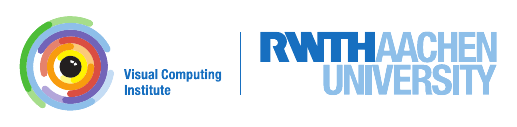</a>
</center>

# Advanced Machine Learning Excercises

**Assistants:**
<br>
Alexey Nekrasov &lt;nekrasov@vision.rwth-aachen.de&gt;
<br>
Jens Piekenbrinck &lt;piekenbrinck@vision.rwth-aachen.de&gt;

The assignments are **NOT** mandatory, but we still encourage you to work on them, in order to gain a deeper understanding.

We want to provide you with an interactive learning experience, so the assignments rely on [Jupyter](https://jupyter.org/) notebooks which you can run locally on your computer. The RWTH also offers a [JupyterHub](jupyter.rwth-aachen.de/) where you can run notebooks. If you have any questions, please contact us.

Make sure you fill in any place in *code cells* that says:
```python
# YOUR CODE HERE
raise NotImplementedError()
```

Make sure you fill in any place in *text cells* that says:
<br>

`YOUR ANSWER HERE`


### Submission:
Before submission remove outputs from the notebooks to prevent sending large files.
With images a hundred submissions could occupy a few GB of space.
To erase the outputs before submission, use a tool [nbstripout](https://github.com/kynan/nbstripout).

Upload all the notebook files with your changes to moodle. **IMPORTANT**: Do not rename files.

⏰ Due date: -

# Exercise 4: Generative Adverserial Networks and Auto Encoders

### Task:
1. Build a GAN model and train the model with MNIST dataset.
2. Update Discrimator network to maximize $\log(D(x)) + \log(1 - D(G(z)))$ and Generator network to minimize $\log(1 - D(G(z))$.

### Running notebooks on Google Colaboratory

* Goto [Google Colab](https://colab.research.google.com/)  
* Under `File` menu, click on `Upload notebook` and upload this notebook  
* To run the notebook with GPU, click on `Runtime` menu, select `Change runtime type`, and select `GPU` as Hardware accelerator  
  
Note:  
* If you see a `“RuntimeError: CUDA error: device-side assert triggered”` error, try running the notebook on CPU (by choosing `None` in Hardware accelerator as discussed above) to get a more detailed traceback for the error.  
* If the notebook is running fine with CPU and the same error persists while using GPU, try restarting the runtime.

Install the needed packages in the current Jupyter kernel.

In [1]:
# import sys
#
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install torch
# !{sys.executable} -m pip install torchvision
# !{sys.executable} -m pip install tqdm

PyTorch is an open source python package for building deep learning models. We will use this package in this exercise. For a basic understanding of the package, see [PyTorch introduction](https://pytorch.org/tutorials/beginner/basics/intro.html).

# Generative Adverserial Networks

In [2]:
import random
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

### Set random seed for reproducibility

In [3]:
seed = 12
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
print("Random Seed: ", seed)

Random Seed:  12


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Create the input data transformations and dataloader

PyTorch has two primitives to work with data: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. `Dataset` stores the  data samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset.  
The `torchvision.datasets` module contains Dataset objects for many real-world vision data. We will use the MNIST dataset of handwritten digits in this exercise.  
Every TorchVision Dataset includes two arguments: `transform` and `target_transform` to modify the data samples and labels respectively. You can use `torchvision.transforms.Compose` to compose multiple transformations together.  
For our MNIST dataset, we can use the `torchvision.transforms.ToTensor` to convert the numpy array to a tensor, and `torchvision.transforms.Normalize` for normalizing the input to the range $\left[-1, 1\right]$.

In [5]:
# Size of the generated images (28x28).
image_size = 28

# Creating the transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
)

# Define the train and test sets from MNIST data
dataset = MNIST("./data", transform=transform, download=True)

### Define the dataloaders

Here we define a batch size for the dataloader, i.e. each element in the dataloader iterable will return a batch of features and labels. Additionally, we can shuffle the data in each epoch.

In [6]:
# Setting the batch size
batch_size = 32

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Plot example dataset

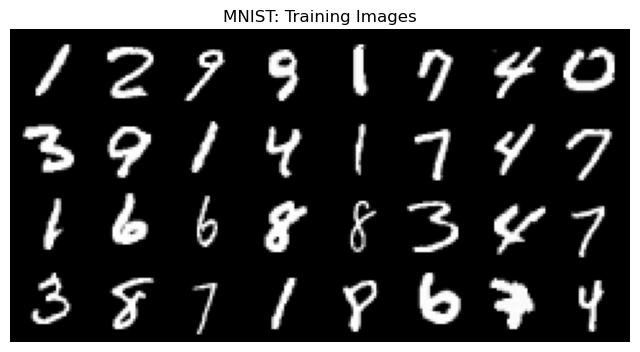

Labels:
[[1 2 9 9 1 7 4 0]
 [3 9 1 4 1 7 4 7]
 [1 6 6 8 8 3 4 7]
 [3 8 7 1 8 6 7 4]]


In [7]:
# Plot some training images
images, labels = next(iter(dataloader))
images = make_grid(
    images[:batch_size],
    padding=2,
    normalize=True,
).cpu()

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("MNIST: Training Images")
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.show()

print("Labels:")
print(labels.reshape(-1, 8).numpy())

### Initialize the parameters of the model

Define a function to initialize the paramters of the model as suggested in the [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf).  


In [8]:
# mean = ...
# std = ...
# YOUR CODE HERE
#raise NotImplementedError()
mean = 0
std = 0.02

def weights_init(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        model.weight.data.normal_(mean, std)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(mean, std)
        model.bias.data.fill_(0)

### Define the generator class

Define a generator class with the following number of output feature maps in the hidden layers: $\left[128, 64, 32\right]$.

Please refer [transposed convolution layer](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html),  [batch normalization layer](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), and [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for defining the network.

The class is to be inherited from the base [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) from PyTorch.

In [9]:
# Define the input latent dimension for Generator
num_latent_features = 10

# Defining the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the generator network to generate fake data.
        
        # self.main = ...

        # YOUR CODE HERE
        self.main = nn.Sequential( ##input =  _ X _ X 1 x 1
            nn.ConvTranspose2d(num_latent_features,128,kernel_size = 4,stride = 1,padding = 0,bias = False), ## _ X _ X 4 X 4
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,bias = False), ## _ X _ X 7 X 7
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1,bias = False), ## _ X _ X 14 X 14
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32,1,kernel_size=4,stride=2,padding=1,bias = False), ## _ X _ X 28 X 28
            nn.Tanh(),
        )
        #raise NotImplementedError()

    def forward(self, z):
        output = self.main(z)
        return output

Instantiate the generator model and initialize the parameters

In [10]:
# Creating the generator
netG = Generator().to(device)
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


### Define the discriminator class

Define a discriminator class with the following number of output feature maps in the hidden layers:  
$\left[32, 64, 128\right]$  

Please refer [convolution layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity), and [batch normalization layer](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) for defining the network.  

The class is to be inherited from the base [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) from PyTorch.

In [11]:
# Defining the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the discriminator network to output a scalar probability of real data.
        # self.main = ...

        # YOUR CODE HERE
        self.main = nn.Sequential( ##input =  _ X _ X 28 x 28
                    nn.Conv2d(1,32,kernel_size=4,stride=2,padding=1,bias = False), ##  _ X _ X 14 x 14
                    nn.LeakyReLU(0.2, inplace=True),

                    nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1,bias = False), ##  _ X _ X 7 x 7
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU(0.2, inplace=True),

                    nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1,bias = False), ##  _ X _ X 4 x 4
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU(0.2, inplace=True),

                    nn.Conv2d(128,1,kernel_size=4,stride=1,padding=0,bias = False),  ##_ X _ X 1 x 1
                    nn.Sigmoid(),
                     )
        #raise NotImplementedError()

    def forward(self, data):
        output = self.main(data)
        return output.view(-1)

Instantiate the generator model and initialize the parameters

In [12]:
# Creating the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


### Define the loss function and optimizers

Discriminator network is trained to maximize $\log(D(x)) + \log(1 - D(G(z)))$ and Generator network to minimize $\log(1 - D(G(z))$.

Binary cross entropy loss has both the terms we need to optimize for GAN.  

$BCE_{n}=-\left[y_{n} \cdot \log x_{n}+\left(1-y_{n}\right) \cdot \log \left(1-x_{n}\right)\right]$  

We need to choose the labels correctly while training to use the needed term from the loss function.  

Also initialize optimizers for both discriminator and generator.

In [13]:
# optimizerD = ...
# optimizerG = ...
# criterion = ...
# YOUR CODE HERE
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
#raise NotImplementedError()

### Define the labels

We define the labels for real and fake samples.  
Also a constant noise is defined which will help us in visualizing the training progress of generator.

In [14]:
# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, num_latent_features, 1, 1, device=device)
real_label = 1
fake_label = 0

A helper function to remove the normalization we added to the dataloader.  
This is useful while plotting the images which require the values to be in the range $\left[0, 1\right]$

In [15]:
def scale(data, mean=0.5, std=0.5):
    return mean + std * data

### Train the model

Train the discriminator to maximize $\log(D(x)) + \log(1 - D(G(z)))$ and Generator network to minimize $\log(1 - D(G(z))$.   

**Perform the following steps while training discriminator:**  
* Iterate over batches of input data in each epoch.
* PyTorch accumulates the parameter gradients on each subsequent backward pass, thus we need to set the gradients explicitly to zero in each iteration to avoid this. This can be done by calling function `zero_grad()` on the network.
* Perform a forward pass in the discriminator with the input batch (ie., real images).
* Define the labels for the input. Note that we only have two labels (ie., real and fake). `torch.full()` fills a tensor with a given value.
* Calculate the loss for this batch of input (ie., maximize $\log(D(x)$).
* Calculate the gradients for the model parameters in the direction of minimizing the loss. The `backward()` function is used on the loss to calculate this gradients.
* Perform a forward pass in the discriminator with the fake batch of images generated by the generator. `torch.randn()` can be used to generate random tensors. `detach()` function can be used on a tensor so that gradients are not backpropogated through this variable. This is needed as we dont need to calculate gradients for generator parameters while training discriminator.
* Calculate the loss for this fake batch of input (ie., maximize $\log(1 - D(G(z))$).
* Calculate the gradients and perform the optimization of discriminator parameters using the gradients. The `step()` function is used on the optimizer to update the parameters.

**Perform the following steps while training generator:**  
* Perform a forward pass in the discriminator with the fake batch of images generated by the generator.
* Calculate the generator's loss (ie., minimize $\log(1 - D(G(z)))$), gradients for the generator parameters and optimize.

⚠️ The training can take a long time, from minutes to half an hour or even more, depending on your hardware!


  0%|          | 0/1875 [00:00<?, ?batch/s]

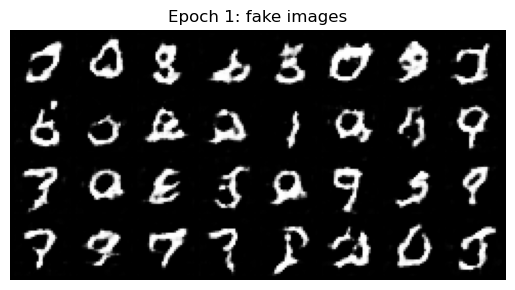

  0%|          | 0/1875 [00:00<?, ?batch/s]

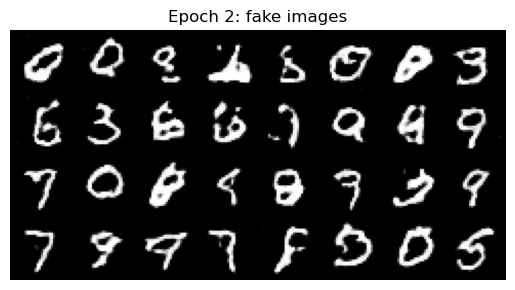

  0%|          | 0/1875 [00:00<?, ?batch/s]

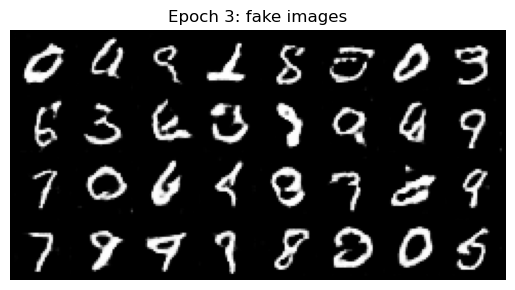

  0%|          | 0/1875 [00:00<?, ?batch/s]

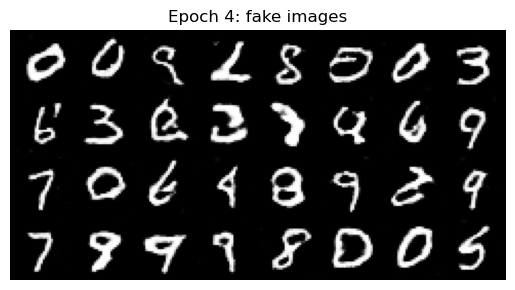

  0%|          | 0/1875 [00:00<?, ?batch/s]

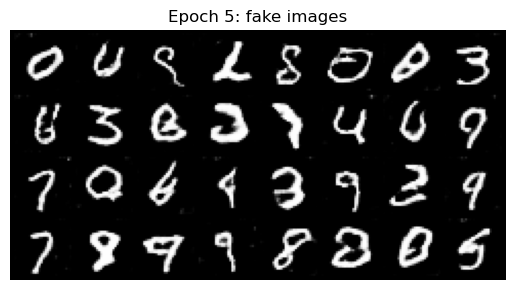

  0%|          | 0/1875 [00:00<?, ?batch/s]

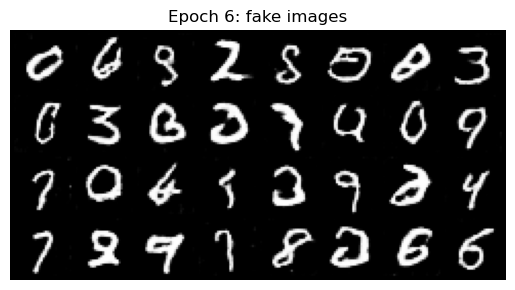

  0%|          | 0/1875 [00:00<?, ?batch/s]

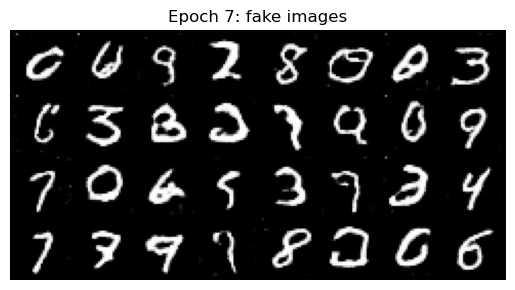

  0%|          | 0/1875 [00:00<?, ?batch/s]

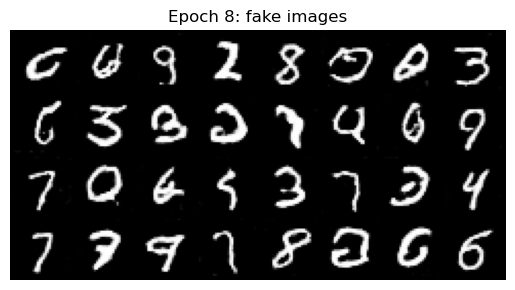

  0%|          | 0/1875 [00:00<?, ?batch/s]

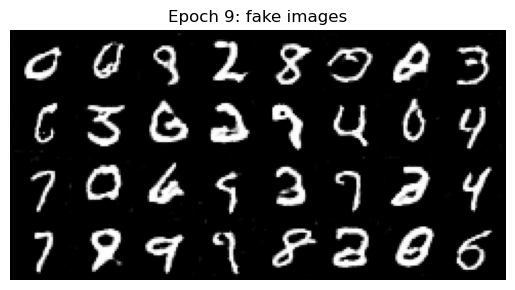

  0%|          | 0/1875 [00:00<?, ?batch/s]

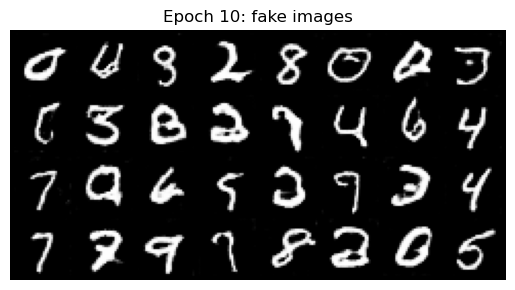

  0%|          | 0/1875 [00:00<?, ?batch/s]

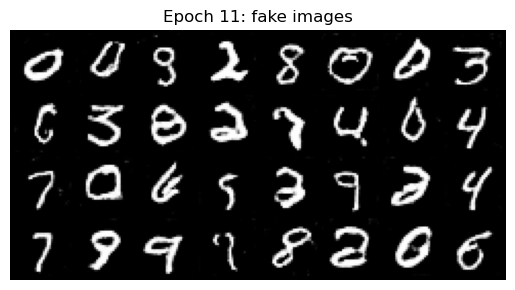

  0%|          | 0/1875 [00:00<?, ?batch/s]

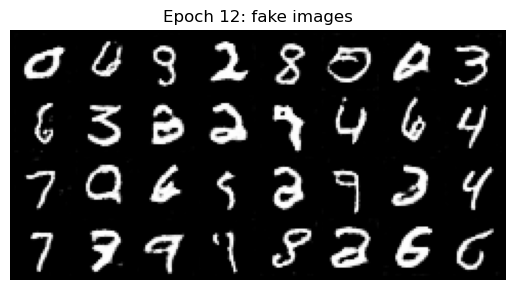

  0%|          | 0/1875 [00:00<?, ?batch/s]

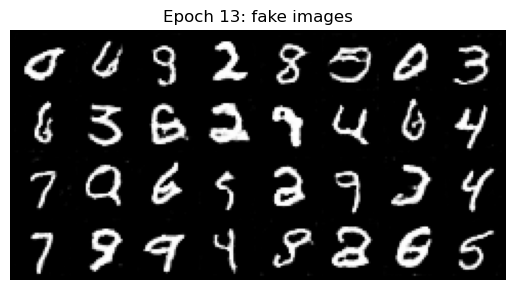

  0%|          | 0/1875 [00:00<?, ?batch/s]

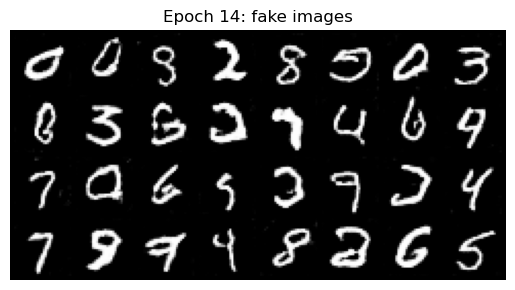

  0%|          | 0/1875 [00:00<?, ?batch/s]

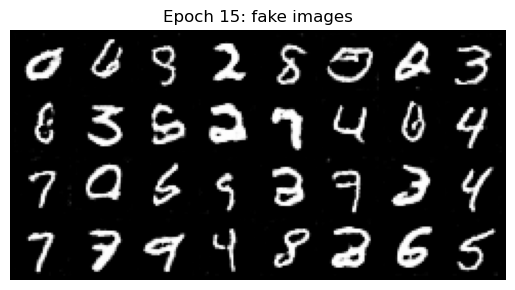

  0%|          | 0/1875 [00:00<?, ?batch/s]

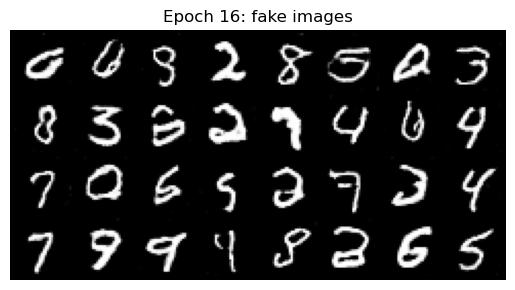

  0%|          | 0/1875 [00:00<?, ?batch/s]

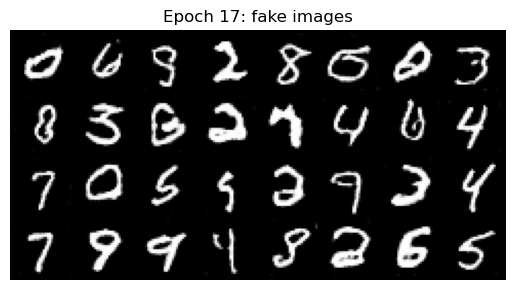

  0%|          | 0/1875 [00:00<?, ?batch/s]

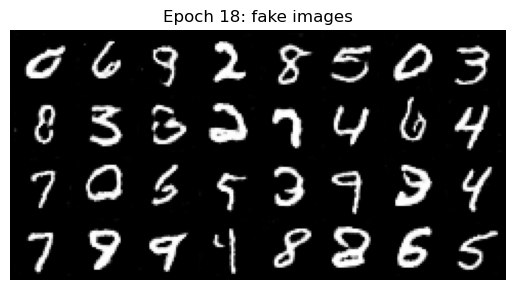

  0%|          | 0/1875 [00:00<?, ?batch/s]

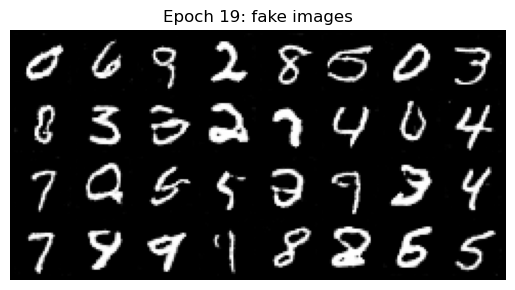

  0%|          | 0/1875 [00:00<?, ?batch/s]

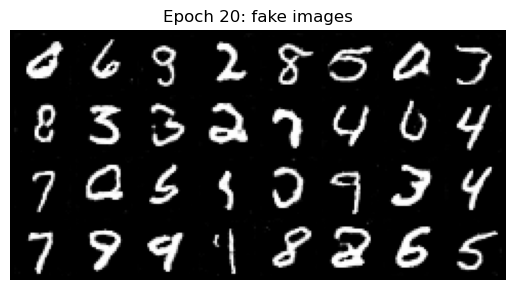

  0%|          | 0/1875 [00:00<?, ?batch/s]

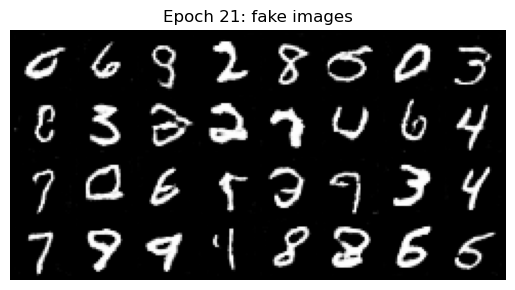

  0%|          | 0/1875 [00:00<?, ?batch/s]

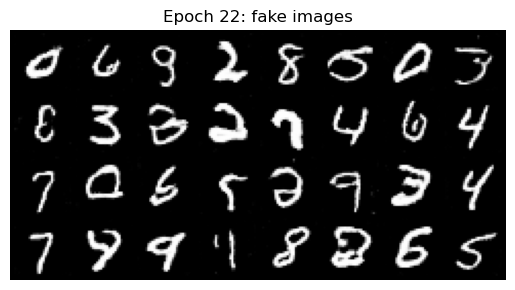

  0%|          | 0/1875 [00:00<?, ?batch/s]

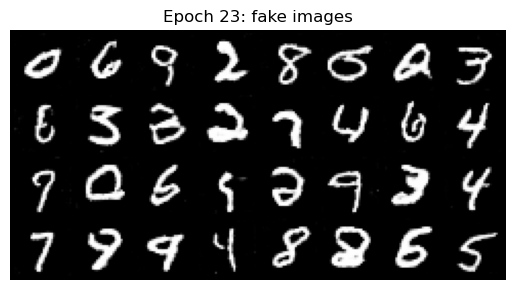

  0%|          | 0/1875 [00:00<?, ?batch/s]

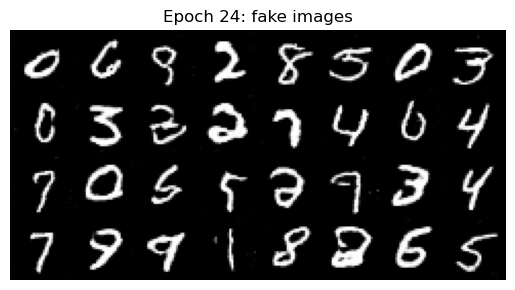

  0%|          | 0/1875 [00:00<?, ?batch/s]

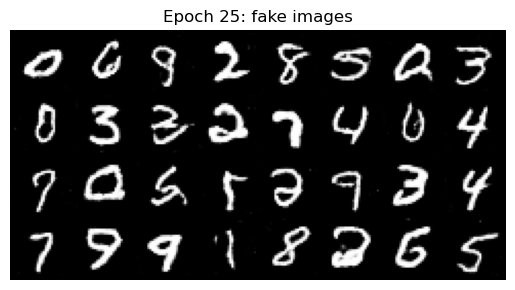

In [16]:
epochs = 25

# Lists to keep track of progress
G_losses = []
D_losses = []

for epoch in range(1, epochs + 1):
    with tqdm(dataloader, unit="batch") as epoch_pbar:
        for data in epoch_pbar:
            epoch_pbar.set_description(f"Epoch {epoch}")
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real data
            netD.zero_grad()
            real_img, _ = data
            real_img = real_img.to(device)

            """
            Calculate the loss for the batch of real inputs and 
            calculate the gradients.
            variable `errD_real` should hold the discriminator loss value for the batch of real inputs which 
            will be used to display the progress of training
            """
            # YOUR CODE HERE
            #raise NotImplementedError()
            label = torch.full((batch_size,),real_label, dtype=real_img.dtype, device=device)
            output = netD(real_img) #log(D(x))
            errD_real = criterion(output,label)
            errD_real.backward()
            #D_x = output.mean().item()
            # train with fake data
            """
            Generate fake data and calculate the loss for the batch of fake inputs and 
            calculate the gradients.
            variable `errD_fake` should hold the discriminator loss value for the batch of fake inputs which 
            will be used to display the progress of training
            """
            # YOUR CODE HERE
            noise = torch.randn(batch_size,10,1,1,device=device)
            fake_img = netG(noise) #G(z)
            label.fill_(fake_label) 
            output = netD(fake_img.detach())# log(1-D(G(z))
            errD_fake = criterion(output,label)
            errD_fake.backward()
            #raise NotImplementedError()

            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()

            """
            Calculate the loss for the batch of fake inputs and 
            optimize the generator parameters with the gradients.
            variable `errG` should hold the generator loss value for the batch of fake inputs which 
            will be used to display the progress of training
            """
            # YOUR CODE HERE
            label.fill_(real_label)
            output = netD(fake_img) # log(D(G(z))
            errG = criterion(output,label)
            errG.backward()
            optimizerG.step()
            #raise NotImplementedError()

            od = OrderedDict()
            od["Dis_loss"] = errD.item()
            od["Gen_loss"] = errG.item()
            epoch_pbar.set_postfix(od)

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

    # test and visualize
    with torch.no_grad():
        norm = plt.Normalize(0, 255)
        fake_img = netG(fixed_noise)
        fake_img = scale(fake_img.cpu())
        fake_img = fake_img.view(batch_size, 1, 28, 28)
        image_grid = make_grid(fake_img, nrow=8)
        image_grid = image_grid.permute(1, 2, 0).numpy()
        plt.axis("off")
        plt.title(f"Epoch {epoch}: fake images")
        plt.imshow(image_grid, cmap="gray", norm=plt.Normalize(0, 255))
        plt.show()

### Plot the training loss

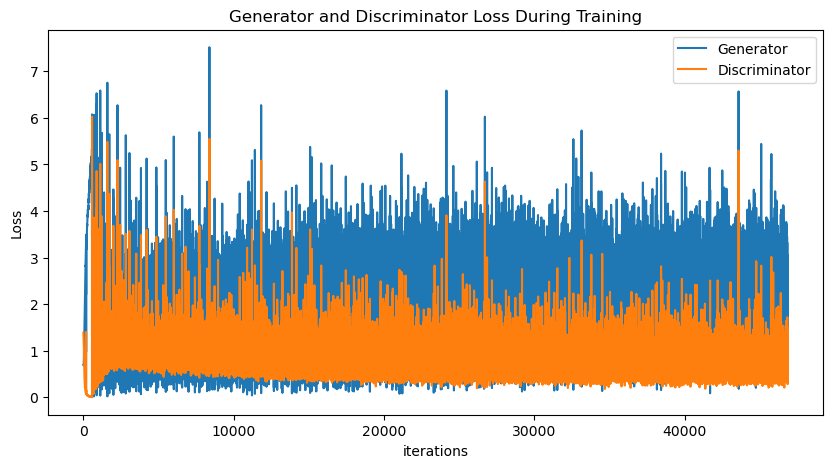

In [17]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()